# Image Classification With Transfer Learning Using Keras

# Task 1: Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Cats vs Dogs Dataset

In [2]:
pets.download_and_extract('data', '.')

In [4]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples', count_train)
print('Test examples', count_test)

Training examples 3680
Test examples 3669


In [5]:
test_annot


{'Abyssinian_201.jpg': 'cat',
 'Abyssinian_202.jpg': 'cat',
 'Abyssinian_204.jpg': 'cat',
 'Abyssinian_205.jpg': 'cat',
 'Abyssinian_206.jpg': 'cat',
 'Abyssinian_207.jpg': 'cat',
 'Abyssinian_20.jpg': 'cat',
 'Abyssinian_210.jpg': 'cat',
 'Abyssinian_212.jpg': 'cat',
 'Abyssinian_213.jpg': 'cat',
 'Abyssinian_215.jpg': 'cat',
 'Abyssinian_216.jpg': 'cat',
 'Abyssinian_217.jpg': 'cat',
 'Abyssinian_219.jpg': 'cat',
 'Abyssinian_21.jpg': 'cat',
 'Abyssinian_220.jpg': 'cat',
 'Abyssinian_221.jpg': 'cat',
 'Abyssinian_223.jpg': 'cat',
 'Abyssinian_224.jpg': 'cat',
 'Abyssinian_225.jpg': 'cat',
 'Abyssinian_226.jpg': 'cat',
 'Abyssinian_228.jpg': 'cat',
 'Abyssinian_22.jpg': 'cat',
 'Abyssinian_230.jpg': 'cat',
 'Abyssinian_232.jpg': 'cat',
 'Abyssinian_24.jpg': 'cat',
 'Abyssinian_25.jpg': 'cat',
 'Abyssinian_26.jpg': 'cat',
 'Abyssinian_27.jpg': 'cat',
 'Abyssinian_29.jpg': 'cat',
 'Abyssinian_2.jpg': 'cat',
 'Abyssinian_30.jpg': 'cat',
 'Abyssinian_31.jpg': 'cat',
 'Abyssinian_32.jpg': 

# Task 3: Get Random Batch

In [11]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    
    indices = np.random.choice(range(total_examples), batch_size)
    
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    
    images = []
    
    for i, index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128,128))
        
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
        images.append(image)
    
    return x, y, images

Displaying first 8 examples..


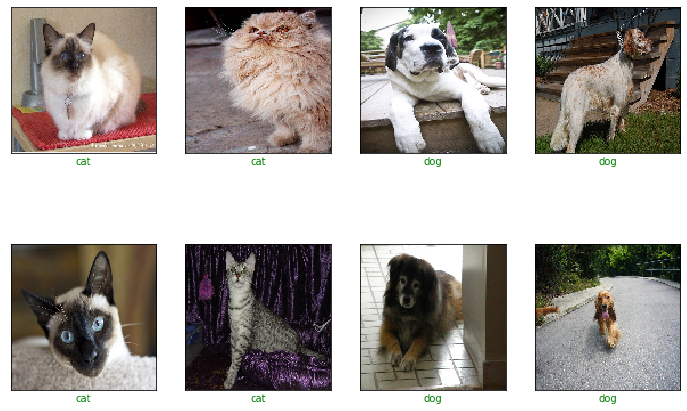

In [12]:
x, y, images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class).show()

# Task 4: Create Model

In [13]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3))

mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
def create_model():
    model = tf.keras.models.Sequential([mnet, tf.keras.layers.Dropout(0.5), tf.keras.layers.Dense(1, activation='sigmoid')])
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Task 5: Model Training

In [16]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x,y)

In [17]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print('Training steps:', steps_per_epoch)
print('Validation steps:', validation_steps)

Training steps: 115
Validation steps: 114


In [19]:
%%time

_ = model.fit_generator(data_generator(batch_size, train_annot), validation_data=data_generator(batch_size, test_annot), steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=1)


115/115 [==============================] - 925s 8s/step - loss: 0.4224 - accuracy: 0.8120 - val_loss: 0.1695 - val_accuracy: 0.9465
Wall time: 15min 25s


# Task 6: Predictions

In [20]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)

Displaying first 8 examples..


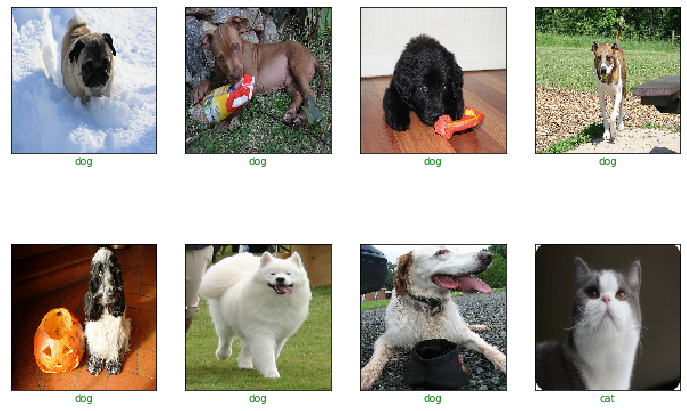

In [21]:
pets.display_examples(x, y, preds, images, index_to_class).show()